# Hybrid network

[![Download JupyterNotebook](https://img.shields.io/badge/Download-Notebook-orange?style=for-the-badge&logo=Jupyter)](https://raw.githubusercontent.com/ANNarchy/ANNarchy.github.io/master/notebooks/Hbrid.ipynb) [![Download JupyterNotebook](https://img.shields.io/badge/Open_in-Colab-blue?style=for-the-badge&logo=Jupyter)](https://colab.research.google.com/github/ANNarchy/ANNarchy.github.io/blob/master/notebooks/Hybrid.ipynb)

In [1]:
#!pip install ANNarchy

Simple example showing hybrid spike/rate-coded networks. 

Reproduces Fig.4 of (Vitay, Dinkelbach and Hamker, 2015)

In [2]:
import numpy as np
import ANNarchy as ann

ann.clear()
ann.setup(dt=0.1)

# Rate-coded input neuron
input_neuron = ann.Neuron(
    parameters = "baseline = 0.0",
    equations = "r = baseline"
)
# Rate-coded output neuron
simple_neuron = ann.Neuron(
    equations = "r = sum(exc)"
)

# Rate-coded population for input
pop1 = ann.Population(geometry=1, neuron=input_neuron)

# Poisson Population to encode
pop2 = ann.PoissonPopulation(geometry=1000, target="exc")
proj = ann.Projection(pop1, pop2, 'exc').connect_all_to_all(weights=1.)

# Rate-coded population to decode
pop3 = ann.Population(geometry=1000, neuron =simple_neuron)
proj = ann.DecodingProjection(pop2, pop3, 'exc', window=10.0)

def diagonal(pre, post, weights):
    """
    Simple connector pattern to progressively connect each post-synaptic neuron to a growing number of pre-synaptic neurons.
    """
    lil = ann.LILConnectivity()
    for rk_post in range(post.size):
        lil.add(rk_post, range((rk_post+1)), [weights], [0] )
    return lil
proj.connect_with_func(method=diagonal, weights=1.)

ann.compile()

# Monitors
m1 = ann.Monitor(pop1, 'r')
m2 = ann.Monitor(pop2, 'spike')
m3 = ann.Monitor(pop3, 'r')

# Simulate
duration = 250.
# 0 Hz
pop1.baseline = 0.0
ann.simulate(duration)
# 10 Hz
pop1.baseline = 10.0
ann.simulate(duration)
# 50 Hz
pop1.baseline = 50.0
ann.simulate(duration)
# 100 Hz
pop1.baseline = 100.0
ann.simulate(duration)

# Get recordings
data1 = m1.get()
data2 = m2.get()
data3 = m3.get()

# Raster plot of the spiking population
t, n = m2.raster_plot(data2['spike'])

# Variance of the the decoded firing rate
data_10 = data3['r'][int(1.0*duration/ann.dt()):int(2*duration/ann.dt()), :]
data_50 = data3['r'][int(2.0*duration/ann.dt()):int(3*duration/ann.dt()), :]
data_100 = data3['r'][int(3.0*duration/ann.dt()):int(4*duration/ann.dt()), :]
var_10 = np.mean(np.abs((data_10 - 10.)/10.), axis=0)
var_50 = np.mean(np.abs((data_50 - 50.)/50.), axis=0)
var_100 = np.mean(np.abs((data_100 - 100.)/100.), axis=0)

ANNarchy 5.0 (5.0.0) on darwin (posix).
Compiling ...  OK 


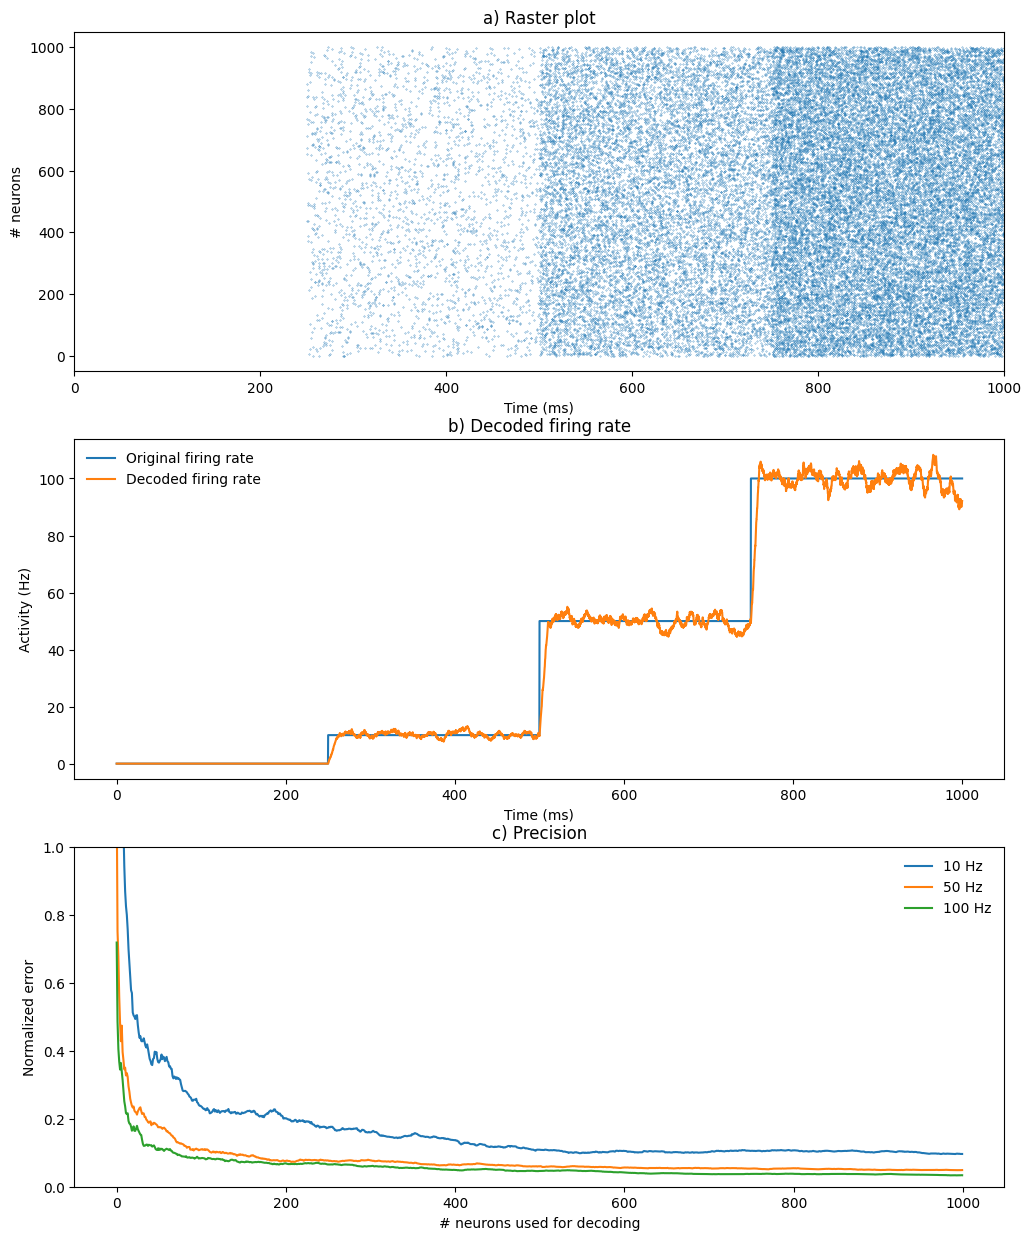

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 15))
plt.subplot(3,1,1)
plt.plot(t, n, '.', markersize=0.5)
plt.title('a) Raster plot')
plt.xlabel('Time (ms)')
plt.ylabel('# neurons')
plt.xlim((0, 4*duration))

plt.subplot(3,1,2)
plt.plot(np.arange(0, 4*duration, 0.1), data1['r'][:, 0], label='Original firing rate')
plt.plot(np.arange(0, 4*duration, 0.1), data3['r'][:, 999], label='Decoded firing rate')
plt.legend(frameon=False, loc=2)
plt.title('b) Decoded firing rate')
plt.xlabel('Time (ms)')
plt.ylabel('Activity (Hz)')

plt.subplot(3,1,3)
plt.plot(var_10, label='10 Hz')
plt.plot(var_50, label='50 Hz')
plt.plot(var_100, label='100 Hz')
plt.legend(frameon=False)
plt.title('c) Precision')
plt.xlabel('# neurons used for decoding')
plt.ylabel('Normalized error')
plt.ylim((0,1))

plt.show()